# Starbucks Capstone Project
### Data Scientist Udacity Nanodegree

#### Hung Trong Huynh
#### July 16th, 2023

## Table of Contents

1. [Project Definition](#definition)
  1. [Project Overview](#overview)
  2. [Project Statement](#statement)
  3. [Metrics](#metric)
2. [Analysis](#analysis)
  1. [Data Exploration](#exploration)
  2. [Data Visualization](#visualization)
3. [Methodology](#methodology)
  1. [Data Preprocessing](#preprocessing)
  2. [Implementation](#implementation)
  3. [Refinement](#refinement)
4. [Results](#result)
  1. [Model Evaluation and Validation](#evaluation)
  2. [Justification](#justification)
5. [Conclusion](#conclusion)
  1. [Reflection](#reflection)
  2. [Improvement](#improvement)

## Project Definition <a name='definition'><a/>

### Project Overview <a name='overview'><a/>

This project contains data set simulating customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

### Project Statement <a name='statement'><a/>

The goal of this project is to combine offer, demographic and transaction data to determine two business questions:
- Which demographic groups response best to which offer type.
- Whether a customer will complete an offer after viewing it.

This goal can be achieved by following below strategies:
- Exploring and visualizing three datasets.
- Preprocessing the data and combining three datasets into one master data.
- Analyzing and visualizaing the master dataset.
- Building some machine learning models and comparing them: Decison Tree, K Nearest Neighbor, Logistic Regression.
- Evaluating the model using accuracy.
- Refining the model by normalizing data using MinMaxScaler, and finding the best parameters using GridSearchCV.
- Justifying the final model.

### Metrics <a name='metric'><a/>

To answer the first question, I will use exploratory data analysis (EDA) to determine which demogaphic groups response best to which offer type.

I will build a machine learning model to classify whether a customer will view and complete an offer or just view it. In order to evaluate this model performance, I will use accuracy. Since we have a simple classification problem with two classes. Accuracy allows us to recognize how predictive the model is by comparing the number of correct predictions with the total number of predictions.

## Analysis <a name='analysis'><a/>

In [1]:
# please uncomment and run the below cell to update seaborn library upto latest version
# then comment it, restart the kernel to aplly change

In [2]:
#!pip install -U seaborn

In [10]:
# import necessary packages
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

% matplotlib inline
pd.options.mode.chained_assignment = None # ignore SettingWithCopyWarning

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration <a name='exploration'><a/>

#### a. Offer data (portfolio.json)

Offers sent during 30-day test period

* id (str/hash) - offer id
* offer_type (str) - type of offer (ie BOGO, discount, informational)
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings) - channels offers delivered (ie web, email, mobile, social)

In addition, there are 3 offer types:
* `BOGO` - buy-one-get-one, a user needs to spend a certain amount to get a reward equal to that threshold amount
* `discount` - a user gains a reward equal to fraction of the amount spent
* `informational` - there is no reward, but neither is there a requisite amount that the user is expected to spend

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
 portfolio.shape

(10, 6)

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
# check for duplicated data
portfolio.duplicated(subset=['id']).sum()

0

In [10]:
# offer type counts
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [11]:
# get available channels
set(itertools.chain(*portfolio.channels.values))

{'email', 'mobile', 'social', 'web'}

- The dataset has 10 rows and 6 columns.
- There are no missing values as well as duplicated offers in the dataset.
- In 10 offers, there are 4 `bogo`, 4 `discount` and 2 `informational` types.
- Another thing we need to pay attention to is that the `channels` column contains list data. There are 4 available channels: `email`, `mobile`, `social`, and `web`. We need to extract them into each column so that we can easily process them later.

#### b. User data (profile.json)

Rewards program users

* age (int) - age of the customer, missing value encoded as 118
* became_member_on (int) - date when customer created an app account, format YYYYMMDD
* gender (str) - gender of the customer (ie M, F, O)
* id (str/hash) - customer id
* income (float) - customer's income

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.shape

(17000, 5)

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
# check for duplicated data
profile.duplicated(subset=['id']).sum()

0

In [17]:
# check if missing values belong to the same user
missed_gender = profile[profile.gender.isnull()].index.tolist()
missed_income = profile[profile.income.isnull()].index.tolist()
missed_age = profile[profile.age == 118].index.tolist()
assert missed_gender == missed_income and missed_gender == missed_age

In [18]:
# gender counts
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

- The dataset contains 17000 demographic data of customers and has no duplicated records.
- There are 2175 users missing both gender, age and income. Actually the `age` column also has missing values, but they were encoded by `118`. We should consider to handle these users or drop them.
- The `became_member_on` column should be converted to datetime data type.
- The `gender` column has 3 values: `M` as male, `F` as female, and `O` as others. Other genders make up only a small part in the dataset.

#### c. Transaction record data (transcript.json)

Event log

* event (str) - record description (ie transaction, offer received, offer viewed, offer completed)
* person (str/hash) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dictionary) - different values depending on event type
  * offer id: (str/hash) not associated with any "transaction"
  * amount: (float) money spent in "transaction"
  * reward: (int) money gained from "offer completed"

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.shape

(306534, 4)

In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [23]:
# event type counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# get all the unique keys in the value column
set(itertools.chain(*transcript.value.apply(lambda x: list(x.keys())).values))

{'amount', 'offer id', 'offer_id', 'reward'}

- There are more than 300000 event logs in the dataset.
- No missing values nor duplicated rows.
- The `time` runs from `0` to `714` hours, means from beginning to the end of 30-day test period.
- There are 4 event types: `transaction`, `offer received`, `offer viewed`, and `offer completed`.
- The `value` column has different values based on event type. There are 3 possible values: `amount`, `offer_id` and `reward`. We should extract them into seperated columns.
- Notice that the key `offer id` and `offer_id` is the same. We should rename it to `offer_id` for consistency.

### Data Visualization <a name='visualization'><a/>

#### a. Offer data

In [25]:
def hist_plot(df, column, title, xlabel, ylabel='Frequency'):
    '''Draw a histogram based on a specific column
    
    Args:
        df (DataFrame): a dataframe
        column (str): column name
        title (str): chart title
        xlabel (str): x-axis label
        ylabel (str): y-axis label (default is "Frequency")
    '''
    plt.hist(df[column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

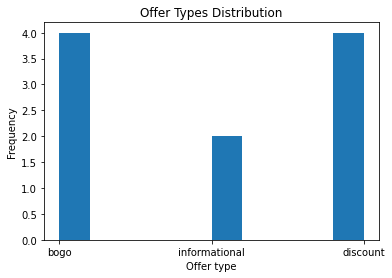

In [26]:
hist_plot(portfolio, 'offer_type', 'Offer Types Distribution', 'Offer type')

- There are 3 offer types in the dataset: 4 `bogo`, 4 `discount`, and 2 `informational`.

#### b. User data

In [27]:
# remove null values
new_profile = profile.dropna()

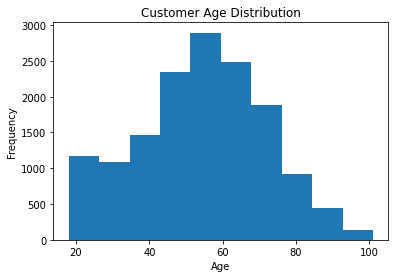

In [28]:
hist_plot(new_profile, 'age', 'Customer Age Distribution', 'Age')

- Customer age distributes from 18 to 101 years old.
- Most of users are in range 50 - 70 years old.

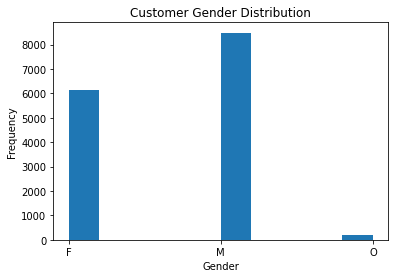

In [29]:
hist_plot(new_profile, 'gender', 'Customer Gender Distribution', 'Gender')

- There are 3 types of gender: female, male, and others.
- Male are more than female about 35%.
- There are only a few users choose other genders or they don't want to reveal their gender.

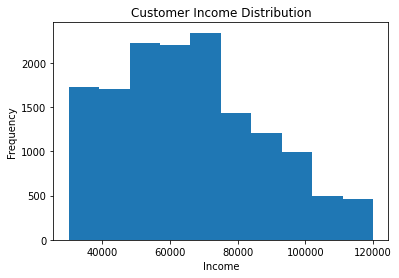

In [30]:
hist_plot(new_profile, 'income', 'Customer Income Distribution', 'Income')

- Customers' incomes are very diverse, ranging from 30,000 to 120,000 dollars.
- Most of customer incomes fall between 50,000 and 75,000 dollars.

#### c. Transaction record data

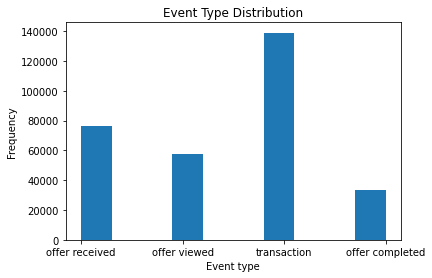

In [31]:
hist_plot(transcript, 'event', 'Event Type Distribution', 'Event type')

- Most of the events are transaction.
- There is a decrease in quantity when a offer is received, then viewed, and finally completed.

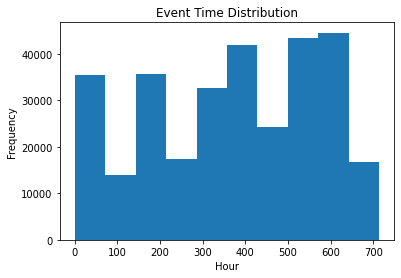

In [32]:
hist_plot(transcript, 'time', 'Event Time Distribution', 'Hour')

- The `time` lasts from 0 to 714 hours (nearly 30 days).
- Seem there is no relationship between time and the number of events per time period.


## Methodology <a name='methodology'><a/>

### Data Preprocessing <a name='preprocessing'><a/>

#### a. Offer data

- Rename `id` column to `offer_id`.
- Replace the `offer_id` by integer ids.
- Create dummy variables from `channels` column using one-hot encoding then drop the `channels` column.
- Replace the `offer_type` by integers representing each offer type as follow:
    1. bogo
    2. discount
    3. informational

In [33]:
# create a copy dataframe
clean_portfolio = portfolio.copy()

In [34]:
# rename `id` column to `offer_id`
clean_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [35]:
def replace_ids(df, column):
    '''Replace values in column by integers, start from 1
    
    Args:
        df (DataFrame): a dataframe
        column (str): column name
        
    Returns:
        df_new (DataFrame): new dataframe after replacing values
        map_ids (dictionary): a dictionary with key is the old id, value is the new id
    '''
    list_ids = df[column].astype('category').cat.categories.tolist()
    map_ids = {k: v for k, v in zip(list_ids, list(range(1, len(list_ids) + 1)))}
    df_new = df.replace({column: map_ids})
    return df_new, map_ids

In [36]:
# replace the `offer_id` by integer ids
clean_portfolio, map_offer_ids = replace_ids(clean_portfolio, 'offer_id')

In [37]:
# create dummy variables from `channels` column
clean_portfolio['channel_email'] = clean_portfolio.channels.apply(lambda x: 1 if 'email' in x else 0)
clean_portfolio['channel_mobile'] = clean_portfolio.channels.apply(lambda x: 1 if 'mobile' in x else 0)
clean_portfolio['channel_social'] = clean_portfolio.channels.apply(lambda x: 1 if 'social' in x else 0)
clean_portfolio['channel_web'] = clean_portfolio.channels.apply(lambda x: 1 if 'web' in x else 0)

In [38]:
# drop `channels` column
clean_portfolio.drop('channels', axis=1, inplace=True)

In [39]:
# replace the `offer_type` by integers
clean_portfolio, map_offer_types = replace_ids(clean_portfolio, 'offer_type')
map_offer_types

{'bogo': 1, 'discount': 2, 'informational': 3}

In [40]:
clean_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,8,1,10,1,1,1,0
1,10,5,5,1,10,1,1,1,1
2,0,4,4,3,0,1,1,0,1
3,5,7,7,1,5,1,1,0,1
4,20,10,1,2,5,1,0,0,1


#### b. User data

- Rename `id` column to `customer_id`.
- Replace the `customer_id` by integer ids.
- Drop rows with no `gender`, `income` (also drop rows with `age` equal 118).
- Convert `became_member_on` column to date format.
- Add a new column `membership_days` presenting the number of days since the customer became a member, to the latest date in dataset.
- Drop the `became_member_on` column since it's no longer needed.
- Convert `income` to integer.
- Replace the `gender` by integers representing each gender as follow:
    1. F (Female)
    2. M (Male)
    3. O (Others)

In [41]:
# create a copy dataframe
clean_profile = profile.copy()

In [42]:
# rename `id` column to `customer_id`
clean_profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [43]:
# replace the `customer_id` by integer ids
clean_profile, map_customer_ids = replace_ids(clean_profile, 'customer_id')

In [44]:
# drop missing values
clean_profile.dropna(inplace=True)

In [45]:
# reset index
clean_profile.reset_index(drop=True, inplace=True)

In [46]:
# convert `became_member_on` to date format
clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d')

In [47]:
# get the latest date
latest_date = clean_profile['became_member_on'].max()
latest_date

Timestamp('2018-07-26 00:00:00')

In [48]:
# add new column `membership_days`
clean_profile['membership_days'] = latest_date.date() - clean_profile['became_member_on'].dt.date
# remove `days` unit
clean_profile['membership_days'] = clean_profile['membership_days'].dt.days

In [49]:
# drop `became_member_on` column
clean_profile.drop('became_member_on', axis=1, inplace=True)

In [50]:
# convert `income` to integer
clean_profile['income'] = clean_profile['income'].astype(int)

In [51]:
# replace the `gender` by integer ids
clean_profile, map_genders = replace_ids(clean_profile, 'gender')
map_genders

{'F': 1, 'M': 2, 'O': 3}

In [52]:
clean_profile.head()

,age,gender,customer_id,income,membership_days
0,55,1,399,112000,376
1,75,1,7997,100000,443
2,68,2,15044,70000,91
3,65,2,3729,53000,167
4,58,2,3060,51000,257


#### c. Transaction record data

- Rename `person` column to `customer_id`.
- Replace the values in `customer_id` with integer values map with each customer in the user data.
- Extract each key in the `value` column to a seperate column: `offer_id`, `amount`, and `reward`.
- Drop the `value` column.
- Drop all the rows with event `transaction` or `offer received`.
- Drop the `amount` and `reward` columns.
- Drop duplicated values.
- Replace the values in `event` with integer values.
    1. offer completed
    2. ofer viewed
- Replace values in `offer_id` with integer values map with each offer in the offer data.

In [53]:
# create a copy dataframe
clean_transcript = transcript.copy()

In [54]:
# rename `person` column to `customer_id`
clean_transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [55]:
# replace values in `customer_id` with integers
clean_transcript.replace({'customer_id': map_customer_ids}, inplace=True)

In [56]:
# create new columns
clean_transcript['offer_id'] = '' # string
clean_transcript['amount'] = 0.0  # float
clean_transcript['reward'] = 0    # int

In [57]:
# update values to new columns based on `value` column
for idx, row in clean_transcript.iterrows():
    for k in row['value']:
        if k == 'offer id':
            clean_transcript.at[idx, 'offer_id'] = row['value'][k]
        else:
            clean_transcript.at[idx, k] = row['value'][k]

In [58]:
# drop the `value` column
clean_transcript.drop('value', axis=1, inplace=True)

In [59]:
clean_transcript.sample(5)

,event,customer_id,time,offer_id,amount,reward
69060,offer viewed,1508,168,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0
290732,transaction,2765,648,,3.55,0
259576,transaction,9542,576,,11.48,0
247233,offer received,9207,576,ae264e3637204a6fb9bb56bc8210ddfd,0.00,0
84227,transaction,2860,210,,28.08,0


In [60]:
# get the transcript only contains transaction event
transaction_df = clean_transcript[clean_transcript.event == 'transaction']
transaction_df.sample(5)

,event,customer_id,time,offer_id,amount,reward
19054,transaction,8821,12,,22.18,0
283718,transaction,13617,624,,26.09,0
224616,transaction,10068,516,,14.58,0
144230,transaction,6135,384,,6.00,0
277397,transaction,2082,612,,1.58,0


In [61]:
# check whether event transaction has offer id
transaction_df[transaction_df.offer_id != '']

,event,customer_id,time,offer_id,amount,reward


- Event `transaction` doesn't have any offer assigned to. Therefore it doesn't help us in this case. We should drop it.

In [62]:
# drop all rows have event `transaction`
clean_transcript = clean_transcript[clean_transcript.event != 'transaction']
clean_transcript.sample(5)

,event,customer_id,time,offer_id,amount,reward
205681,offer received,13142,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
212747,offer received,7466,504,5a8bc65990b245e5a138643cd4eb9837,0.0,0
260098,offer viewed,16781,576,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
237165,offer completed,8958,546,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5
80676,offer viewed,16390,198,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0


In [63]:
# check the amount
clean_transcript.amount.sum()

0.0

- The `amount` column has value `0` for all 3 remaining events. We should drop it too.

In [64]:
# drop the `amount` column
clean_transcript.drop('amount', axis=1, inplace=True)

- Since we're interested in whether the offer only viewed or completed, so we will drop the offer received but not viewed.

In [65]:
# drop all rows have event `offer received`
clean_transcript = clean_transcript[clean_transcript.event != 'offer received']

In [66]:
# check for duplicated
clean_transcript.duplicated().sum()

397

- The duplicated values here is because an user could order the same offer type in the same hour.

In [67]:
# drop the duplicated values
clean_transcript.drop_duplicates(inplace=True)

In [68]:
# replace values in `event` with integers
clean_transcript, map_events  = replace_ids(clean_transcript, 'event')
map_events

{'offer completed': 1, 'offer viewed': 2}

In [69]:
# replace values in `offer_id` with integers
clean_transcript.replace({'offer_id': map_offer_ids}, inplace=True)

In [70]:
clean_transcript.sample(5)

,event,customer_id,time,offer_id,reward
263169,2,1110,582,9,0
226606,2,13979,522,7,0
230646,2,5158,534,5,0
289143,1,3220,642,1,5
68813,1,2262,168,10,2


In [71]:
# check the reward of event 2 - offer viewed
clean_transcript[clean_transcript.event == 2].reward.sum()

0

In [72]:
# get the reward of event 1 - offer completed
offer_completed = clean_transcript[clean_transcript.event == 1].groupby('offer_id')['reward']

In [73]:
# get number of unique reward and the max value
offer_completed.agg(['nunique', 'max'])

,nunique,max
offer_id,,
1,1,5
2,1,3
3,1,2
5,1,10
7,1,5
8,1,10
9,1,5
10,1,2


In [74]:
# compare with offer data
clean_portfolio[['offer_id', 'reward']].sort_values(by='offer_id')

,offer_id,reward
4,1,5
5,2,3
9,3,2
2,4,0
1,5,10
7,6,0
3,7,5
0,8,10
8,9,5
6,10,2


- If an event is `offer completed`, it has a reward. Event `offer viewed` doesn't.
- The reward in `transcript` totally similar to the reward in `porfolio`.
- The `offer completed` doesn't have the offer `4` and `6`, which is informational offer type. That means informational type is only in `offer viewed`.
- Based on that, after merging `transcript` and `portfolio`, the `reward` doesn't have meaningful, so we should drop it.

In [75]:
# drop the `reward` column
clean_transcript.drop('reward', axis=1, inplace=True)

In [76]:
clean_transcript.head()

,event,customer_id,time,offer_id
12650,2,3729,0,9
12651,2,13995,0,6
12652,2,1052,0,5
12653,2,170,0,8
12655,2,12744,0,6


**Merging three cleaned datasets into one master clean dataset**

In [77]:
# merge `clean_transcript` wih `clean_portfolio` on `offer_id`
master_df = clean_transcript.merge(clean_portfolio, how='left', on='offer_id')

In [78]:
# merge `master_df` wih `clean_profile` on `customer_id`
master_df = master_df.merge(clean_profile, how='left', on='customer_id')

In [79]:
# check for null values
master_df.isna().sum()

event                 0
customer_id           0
time                  0
offer_id              0
difficulty            0
duration              0
offer_type            0
reward                0
channel_email         0
channel_mobile        0
channel_social        0
channel_web           0
age                8977
gender             8977
income             8977
membership_days    8977
dtype: int64

In [80]:
# drop all rows have missing values
master_df.dropna(inplace=True)

In [81]:
master_df.head()

,event,customer_id,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_days
0,2,3729,0,9,5,5,1,5,1,1,1,1,65.0,2.0,53000.0,167.0
1,2,13995,0,6,0,3,3,0,1,1,1,0,53.0,3.0,52000.0,313.0
2,2,1052,0,5,10,5,1,10,1,1,1,1,69.0,1.0,57000.0,711.0
3,2,170,0,8,10,7,1,10,1,1,1,0,20.0,1.0,30000.0,745.0
4,2,12744,0,6,0,3,3,0,1,1,1,0,39.0,2.0,51000.0,1521.0


In [82]:
# convert `age`, `gender`, `income` and `membership_days` to integer
master_df = master_df.astype('int64')

In [83]:
master_df.head()

,event,customer_id,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_days
0,2,3729,0,9,5,5,1,5,1,1,1,1,65,2,53000,167
1,2,13995,0,6,0,3,3,0,1,1,1,0,53,3,52000,313
2,2,1052,0,5,10,5,1,10,1,1,1,1,69,1,57000,711
3,2,170,0,8,10,7,1,10,1,1,1,0,20,1,30000,745
4,2,12744,0,6,0,3,3,0,1,1,1,0,39,2,51000,1521


In [84]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81930 entries, 0 to 90906
Data columns (total 16 columns):
event              81930 non-null int64
customer_id        81930 non-null int64
time               81930 non-null int64
offer_id           81930 non-null int64
difficulty         81930 non-null int64
duration           81930 non-null int64
offer_type         81930 non-null int64
reward             81930 non-null int64
channel_email      81930 non-null int64
channel_mobile     81930 non-null int64
channel_social     81930 non-null int64
channel_web        81930 non-null int64
age                81930 non-null int64
gender             81930 non-null int64
income             81930 non-null int64
membership_days    81930 non-null int64
dtypes: int64(16)
memory usage: 10.6 MB


In [85]:
# save the master df to use later
master_df.to_csv('master.csv', index=False)

In [2]:
# read the master_df from csv file
master_df = pd.read_csv('master.csv')
master_df.head()

,event,customer_id,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_days
0,2,3729,0,9,5,5,1,5,1,1,1,1,65,2,53000,167
1,2,13995,0,6,0,3,3,0,1,1,1,0,53,3,52000,313
2,2,1052,0,5,10,5,1,10,1,1,1,1,69,1,57000,711
3,2,170,0,8,10,7,1,10,1,1,1,0,20,1,30000,745
4,2,12744,0,6,0,3,3,0,1,1,1,0,39,2,51000,1521


- Everything is clean now. We're able to use `master_df` to answer our questions.

### Implementation <a name='implementation'><a/>

#### 1. Which demographic groups response best to which offer type?

- To answer this question, we will walk through 4 demographic features: age, gender, income and number of membership days.
- We only select the users who completed the offers.

In [87]:
# create a new df with decoded offer types and genders
master_df2 = master_df.replace({'offer_type': {1: 'bogo', 2: 'discount', 3: 'informational'}})
master_df2 = master_df2.replace({'gender': {1: 'female', 2: 'male', 3: 'others'}})
master_df2 = master_df2[master_df2['event'] == 1] # select offer completed

In [88]:
# create an age count table
age_count = master_df2[['age', 'offer_type']]
age_count['count'] = 1 # default value
age_count = age_count.groupby(['age', 'offer_type'], as_index=False).sum()
age_count.head()

,age,offer_type,count
0,18,bogo,55
1,18,discount,71
2,19,bogo,85
3,19,discount,104
4,20,bogo,101


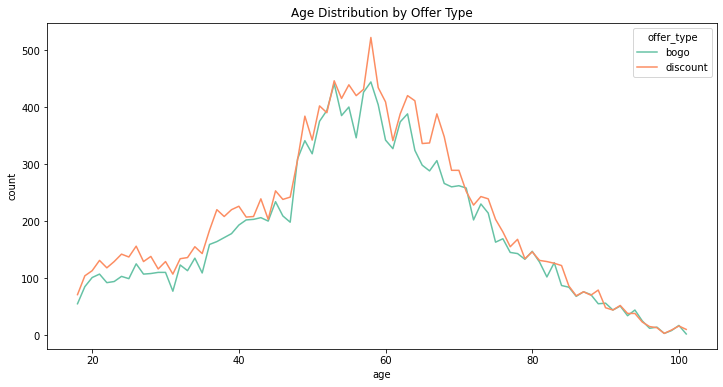

In [89]:
# visualize the age distribution by offer type
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_count, x='age', y='count', hue='offer_type', palette='Set2')
plt.title('Age Distribution by Offer Type')
plt.show()

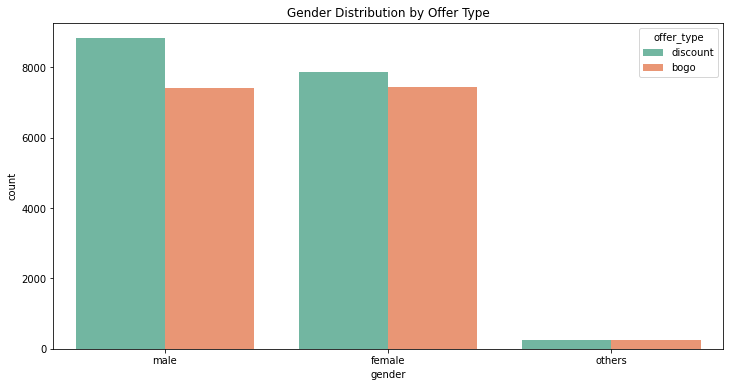

In [90]:
# visualize the gender distribution by offer type
plt.figure(figsize=(12, 6))
sns.countplot(data=master_df2, x='gender', hue='offer_type', palette='Set2')
plt.title('Gender Distribution by Offer Type')
plt.show()

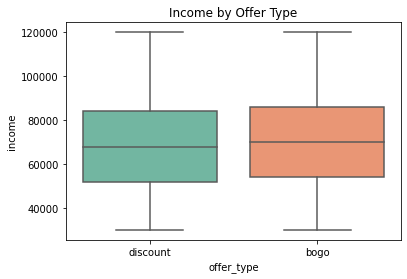

In [91]:
# visualize the income by offer type
sns.boxplot(data=master_df2, x='offer_type', y='income', palette='Set2')
plt.title('Income by Offer Type')
plt.show()

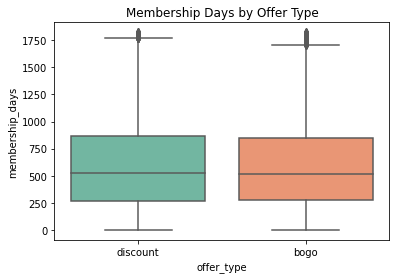

In [92]:
# visualize the membership days by offer type
sns.boxplot(data=master_df2, x='offer_type', y='membership_days', palette='Set2')
plt.title('Membership Days by Offer Type')
plt.show()

**Observation**
- We don't see the `informational` offer type in the charts, because users only view it but not make a purchase.
- In general, `discount` is choosen more than `bogo`.
- People in age 50 - 70 years old often buy Starbuck products than others.
- Male seems like `discount` more than `female`.
- Users like `bogo` have income a litte bit higher than `discount`.
- Most of customers have income in range 55,000 and 85,000.
- Membership days look the same for both offer types, usually in range 250 to 875 days.

#### 2. Use a machine learning model to predict whether a user completes an offer after viewing it or not

- To solve this problem, I will try to use 3 different machine learning models: Decision Tree, K Nearest Neighbors, and Logistic Regression.

In [3]:
# create features and target tables
X = master_df.drop(['event', 'customer_id'], axis=1)
Y = master_df['event']

In [4]:
X.head()

,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_days
0,0,9,5,5,1,5,1,1,1,1,65,2,53000,167
1,0,6,0,3,3,0,1,1,1,0,53,3,52000,313
2,0,5,10,5,1,10,1,1,1,1,69,1,57000,711
3,0,8,10,7,1,10,1,1,1,0,20,1,30000,745
4,0,6,0,3,3,0,1,1,1,0,39,2,51000,1521


In [5]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: event, dtype: int64

In [6]:
# create training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [7]:
# define a function to calculate the accuracy for the models
def predict_score(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return round(accuracy * 100, 2)

**Decision Tree**

In [11]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

print(f'Accuracy on training set: {round(dtc.score(X_train, y_train) * 100, 2)}%')
print(f'Prediction accuracy: {predict_score(dtc)}%')

Accuracy on training set: 97.6%
Prediction accuracy: 57.72%


**K Nearest Neighbors**

In [8]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

print(f'Accuracy on training set: {round(knc.score(X_train, y_train) * 100, 2)}%')
print(f'Prediction accuracy: {predict_score(knc)}%')

Accuracy on training set: 70.33%
Prediction accuracy: 53.57%


**Logistic Regression**

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(f'Accuracy on training set: {round(lr.score(X_train, y_train) * 100, 2)}%')
print(f'Prediction accuracy: {predict_score(lr)}%')

Accuracy on training set: 61.47%
Prediction accuracy: 60.79%


- The Decision Tree and K Nearest Neighbors have accuracy on training sets more than Logistic Regression. But on test set, they're opposite. This may be due to overfitting.
- Therefore I choose the Logistic Regression model. The accuracy on both training and testing sets are quite low, about 61%, but it's not overfitting.
- We will fine tune this Logistic Regression model to improve it.

### Refinement <a name='refinement'><a/>

In [99]:
# normalize some numerical values
scaler = MinMaxScaler()
features = ['time', 'reward', 'difficulty', 'duration', 'age', 'income', 'membership_days']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time,offer_id,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age,gender,income,membership_days
0,0.0,9,0.25,0.285714,1,0.5,1,1,1,1,0.566265,2,0.255556,0.091607
1,0.0,6,0.00,0.000000,3,0.0,1,1,1,0,0.421687,3,0.244444,0.171695
2,0.0,5,0.50,0.285714,1,1.0,1,1,1,1,0.614458,1,0.300000,0.390016
3,0.0,8,0.50,0.571429,1,1.0,1,1,1,0,0.024096,1,0.000000,0.408667
4,0.0,6,0.00,0.000000,3,0.0,1,1,1,0,0.253012,2,0.233333,0.834339


In [100]:
# use grid search cv to find the best params
param_grid = {'C': [ 0.01, 0.1, 1, 10, 100] , 'penalty': ['l1', 'l2']}

# initiate the model
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# train the model
clf.fit(X_scaled, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [101]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 0.1, 'penalty': 'l1'}
0.635811058220432


## Results <a name='result'><a/>

### Model Evaluation and Validation <a name='evaluation'><a/>

In [14]:
# create the variables that will be used to fill the results table
models = [dtc, knc, lr]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train) * 100 for x in models]
predection_accuracy = [predict_score(y) for y in models]

In [15]:
# structure a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy'])
results_df

,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression
Training Accuracy,97.596303,70.333784,61.465979
Predicting Accuracy,57.720000,53.570000,60.790000


- The above table shows the accuracy score related with using different machine learning models.
- The Decision Tree and K Nearest Neighbors have accuracy on training sets more than Logistic Regression. But on test set, they're opposite. This may be due to overfitting.
- To avoid overfitting as much as possible, I will choose the model that gave me the predicting accuracy high but not too far from the accuracy on the training set, which is Linear Regression.

Refining the Logistic Regression model:
- I use min max scaler to normalize numeric values to the range 0 and 1. It preserves the shape of the original distribution and helps our model better.
- Then I use grid search cv to find the best parameters. I check for 2 parameters: `C` (inverse of regularization strength) and `penalty` (the norm of the penalty). The grid search cv uses 5-fold cross validation, and `accuracy` to evaluate the performance of the cross-validated model on the test set.
- Finally, the best parameters is `0.1 C` and `l1 penalty`. The accuracy is about 64% on both training and testing datasets.

In [102]:
# create a model with best parameters
best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
# Print accuracy of the model on training and testing dataset
print(f'Accuracy on training set: {round(best_model.score(X_train, y_train) * 100, 2)}%')
print(f'Prediction accuracy: {predict_score(best_model)}%')

Accuracy on training set: 64.47%
Prediction accuracy: 64.1%


### Justification <a name='justification'><a/>

- On Logistic Regression model, I got about 61% on both testing and training set. I choose this model because I believe that it can be used to solve the binary outcome problem: whether the customer will just view the offer or complete it. It's also not overfitting like Decision Tree or K Nearest Neighbors.
- After we fine tune the model, the accuracy increase from `61%` to `64%`. Although the accuracy is still low, the model has been improved.

## Conclusion <a name='conclusion'><a/>

### Reflection <a name='reflection'><a/>

Overall, I found this project interesting and challenging, mainly due to the structure of the data. I had started out with two business questions:
- Which demographic groups respond best to which offer type.
- And create a machine learning model to predict whether a customer will complete an offer after viewing it or not.

With Explanatory Data Analysis, I found some insights in this dataset:
- Customers like `discount` a little bit more than `bogo`.
- For people like `bogo`, they have income a little bit higher.
- Male like `discount` more than female.
- People having age 50 - 70 and income 55,000 - 85,000, and membership days in 250 - 875 days respond most to offer. So it's good to send `bogo` and `discount` to these people.

I also created a machine learning model using Logistic Regression with hyperparameter tuning to predict whether a customer will complete an offer by making transaction after viewing the offer with the accuracy of 64%.

The preprocessing step was the longest and most challenging part to complete. It took me about 80% of time to clean the dataset. But it's worth because preprocessing the data gives us a more accurate view of the data, while increasing the accuracy of the model.

### Improvement <a name='improvement'><a/>

- Build machine learning pipeline to seamlessly classify new data.
- Use other machine learning models.
- Deploy machine learning model to web.

### References

- [How to replace a pandas column with a dict](https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict-preserve-nans)
- [How to fix seaborn module has no attribute lineplot](https://stackoverflow.com/questions/51846948/seaborn-lineplot-module-object-has-no-attribute-lineplot)
- [How to fine tune logistic regression model](https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression)